### Data Loading and Preparation

In [30]:
# Load data from training data directory, convert from NPZ to tensor, and save to a dict
# containing lift name and tensor data

import os
import torch
import numpy as np
import functions
import matplotlib.pyplot as plt

DEADLIFT_TENSORS = {}
BENCH_TENSORS = {}
SQUAT_TENSORS = {}

# Setup paths
script_dir = os.path.dirname(os.path.abspath("model_train.ipynb"))
data_dir = os.path.normpath(os.path.join(script_dir, '..', 'lift data'))

# Step 1: Get all subfolder names in data_dir, A.K.A lift_data
subfolders = []
for f in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, f)):
        subfolders.append(f)


#  Squat Files
#  Bench Files
#  Deadlift Files
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)
    files = []

    # Isolate individual lift files in each of the subfolders (bench files, squat files, deadlift files) and add them to files list
    for f in os.listdir(subfolder_path):
        if os.path.isfile(os.path.join(subfolder_path, f)):
            files.append(f)

    # Iterate through files in each subfolder
    for file in files:
        data = np.load(os.path.join(subfolder_path, file))

        # convert each landmark/angle to a tensor and add it to the tensor dict (which is
        # specific to the current lift only
        tensor_dict = {}
        for key in data.files:
            lift_name_without_video_type = " ".join(key.split('.')[:1] + key.split("_")[-2:])
            tensor_dict[lift_name_without_video_type] = torch.tensor(data[key])
        if file.split('.')[0].startswith('bench'):
            BENCH_TENSORS[file.split('.')[0]] = tensor_dict
        if file.split('.')[0].startswith('deadlift'):
            DEADLIFT_TENSORS[file.split('.')[0]] = tensor_dict
        if file.split('.')[0].startswith('squat'):
            SQUAT_TENSORS[file.split('.')[0]] = tensor_dict

In [31]:
BENCH_TENSORS['bench 3 good lift data'].keys()

dict_keys(['bench 3 good landmark 0', 'bench 3 good landmark 1', 'bench 3 good landmark 2', 'bench 3 good landmark 3', 'bench 3 good landmark 4', 'bench 3 good landmark 5', 'bench 3 good landmark 6', 'bench 3 good landmark 7', 'bench 3 good landmark 8', 'bench 3 good landmark 9', 'bench 3 good landmark 10', 'bench 3 good landmark 11', 'bench 3 good landmark 12', 'bench 3 good landmark 13', 'bench 3 good landmark 14', 'bench 3 good landmark 15', 'bench 3 good landmark 16', 'bench 3 good landmark 17', 'bench 3 good landmark 18', 'bench 3 good landmark 19', 'bench 3 good landmark 20', 'bench 3 good landmark 21', 'bench 3 good landmark 22', 'bench 3 good landmark 23', 'bench 3 good landmark 24', 'bench 3 good landmark 25', 'bench 3 good landmark 26', 'bench 3 good landmark 27', 'bench 3 good landmark 28', 'bench 3 good landmark 29', 'bench 3 good landmark 30', 'bench 3 good landmark 31', 'bench 3 good landmark 32', 'bench 3 good left elbow', 'bench 3 good right elbow', 'bench 3 good left k

In [32]:
BENCH_TENSORS['bench 3 good lift data']['bench 3 good left elbow']

tensor([159, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162,
        162, 163, 163, 163, 163, 163, 163, 163, 163, 162, 162, 163, 163, 163,
        163, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 162, 162, 162, 162, 162, 162, 162, 162, 161, 160, 160, 160, 160,
        159, 159, 159, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        160, 160, 160, 160, 160, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 160, 160, 160, 161, 161, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 159, 159, 159, 159, 159, 158, 157, 156, 155, 154, 154, 153,
        153, 152, 150, 149, 147, 145, 143, 140, 137, 133, 129, 125, 122, 118,
        115, 110, 106, 103,  99,  96,  94,  91,  89,  87,  87,  87,  88,  90,
         93,  96,  99, 104, 107, 111, 114, 118, 118, 116, 115, 1

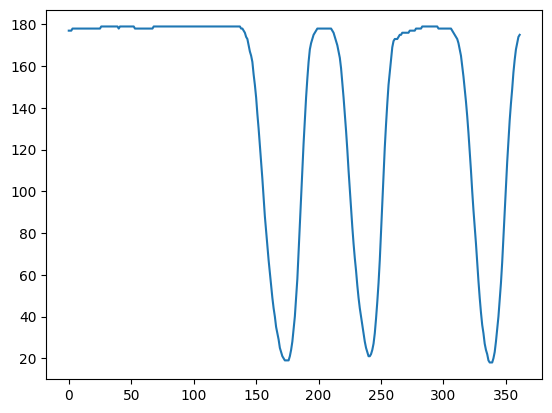

In [33]:
plt.figure()
plt.plot(BENCH_TENSORS['bench 3 good lift data']['bench 3 good right elbow'])

In [34]:
for k,v in BENCH_TENSORS.items():
    print(k)
    for key in v.keys():

        try:
            print(f"---{key} contains a {type(v[key])} containing Z coords for {functions.landmark_indeces_to_labels[int(key.split(' ')[-1])]} that contains ({len(v[key])} points)")
        except:
            print(f"---{key} contains a {type(v[key])} containing joint angles for {' '.join(key.split('_')[-2:])} that contains ({len(v[key])} angles)")


bench 1 good lift data
---bench 1 good landmark 0 contains a <class 'torch.Tensor'> containing Z coords for nose that contains (3 points)
---bench 1 good landmark 1 contains a <class 'torch.Tensor'> containing Z coords for left eye inner that contains (3 points)
---bench 1 good landmark 2 contains a <class 'torch.Tensor'> containing Z coords for left eye that contains (3 points)
---bench 1 good landmark 3 contains a <class 'torch.Tensor'> containing Z coords for left eye outer that contains (3 points)
---bench 1 good landmark 4 contains a <class 'torch.Tensor'> containing Z coords for right eye inner that contains (3 points)
---bench 1 good landmark 5 contains a <class 'torch.Tensor'> containing Z coords for right eye that contains (3 points)
---bench 1 good landmark 6 contains a <class 'torch.Tensor'> containing Z coords for right eye outer that contains (3 points)
---bench 1 good landmark 7 contains a <class 'torch.Tensor'> containing Z coords for left ear that contains (3 points)
--

In [35]:
for key, value in DEADLIFT_TENSORS.items():
    print(key)
    # for landmark, coordinate in BENCH_TENSORS[key].items():
    #     return (landmark, coordinate[2])

deadlift 1 good lift data
deadlift 2 good lift data
deadlift 3 good lift data
deadlift 4 good lift data
deadlift 5 good lift data
deadlift 6 good lift data
deadlift 7 good lift data
deadlift 8 good lift data
deadlift 9 good lift data


In [36]:
# Get the keys within an individual lift

DEADLIFT_TENSORS['deadlift 6 good lift data'].keys()

dict_keys(['deadlift 6 good landmark 0', 'deadlift 6 good landmark 1', 'deadlift 6 good landmark 2', 'deadlift 6 good landmark 3', 'deadlift 6 good landmark 4', 'deadlift 6 good landmark 5', 'deadlift 6 good landmark 6', 'deadlift 6 good landmark 7', 'deadlift 6 good landmark 8', 'deadlift 6 good landmark 9', 'deadlift 6 good landmark 10', 'deadlift 6 good landmark 11', 'deadlift 6 good landmark 12', 'deadlift 6 good landmark 13', 'deadlift 6 good landmark 14', 'deadlift 6 good landmark 15', 'deadlift 6 good landmark 16', 'deadlift 6 good landmark 17', 'deadlift 6 good landmark 18', 'deadlift 6 good landmark 19', 'deadlift 6 good landmark 20', 'deadlift 6 good landmark 21', 'deadlift 6 good landmark 22', 'deadlift 6 good landmark 23', 'deadlift 6 good landmark 24', 'deadlift 6 good landmark 25', 'deadlift 6 good landmark 26', 'deadlift 6 good landmark 27', 'deadlift 6 good landmark 28', 'deadlift 6 good landmark 29', 'deadlift 6 good landmark 30', 'deadlift 6 good landmark 31', 'deadli

In [37]:
all_deadlift_joint_angles = functions.joint_angles_to_list(DEADLIFT_TENSORS)
all_bench_joint_angles = functions.joint_angles_to_list(BENCH_TENSORS)
all_squat_joint_angles = functions.joint_angles_to_list(SQUAT_TENSORS)

# Example of one output for one lift (in this case, deadlift 1 good is the first to be
# processed, so it is at index 0 of our array. We can now iterate over this array with our
# model to learn patterns
all_squat_joint_angles

[{'name': 'squat',
  'viewing from': 'left',
  'label': 'good',
  'angles': {'left elbow': tensor([ 83,  82,  80,  80,  80,  84,  94, 104, 115, 122, 125, 127, 128, 127,
           127, 127, 178, 178, 178, 178, 178, 178, 178, 178, 178, 177, 177, 176,
           176, 175, 175, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175,  21,
            20,  19,  17,   3,   3,   3,   3,   4,   4,   4,   5,   5,   5,   5,
             5,   5,   4,   4,   4,   3,   3,   4,   4,   4,   4,   4,   4,   4,
             4,   4,  20,  36], dtype=torch.int32),
   'right elbow': tensor([115, 104,  94,  84,  74,  65,  55,  56,  58,  61,  63,  65,  67,  69,
            71,  73, 174, 174, 175, 175, 174, 175, 175, 175, 175, 174, 174, 174,
           172, 172, 170, 170, 169, 174, 173, 173, 173, 172, 173, 172, 172,  14,
            14,  14,  14,   5,   5,   5,   5,   5,   5,   5,   4,   4,   3,   3,
             3,   3,   4,   5,   5,   6,   7,   7,   8,   9,  10,   9,   9,   8,
             8,   8,  24,  41], dty

### Split Tensors into individual reps to then be batched

In [38]:
import random

def split_data(data_list, train_ratio, seed):
    random.seed(seed)
    random.shuffle(data_list)
    split_index = int(len(data_list) * train_ratio)
    train_set = data_list[:split_index]
    test_set = data_list[split_index:]
    return train_set, test_set

train_ratio = 1
seed=45

deadlift_train, deadlift_test = split_data(all_deadlift_joint_angles, train_ratio, seed)
bench_train, bench_test = split_data(all_bench_joint_angles, train_ratio, seed)
squat_train, squat_test = split_data(all_squat_joint_angles, train_ratio, seed)

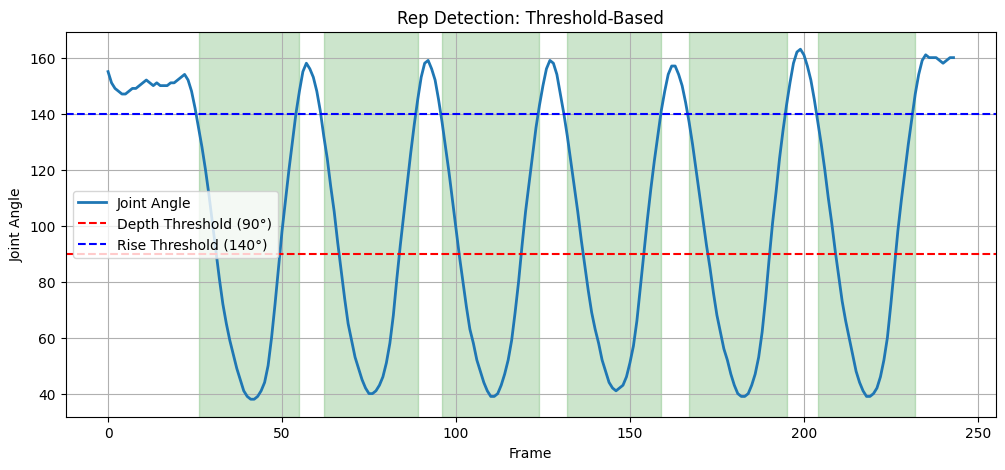

[(26, 55), (62, 89), (96, 124), (132, 159), (167, 195), (204, 232)]

In [39]:
# EXAMPLE OF SPLITTING LIFT DATA INTO INDIVIDUAL REPS
# via ChatGPT
from scipy.signal import find_peaks, savgol_filter
import torch
import numpy as np
import matplotlib.pyplot as plt

def detect_reps_by_threshold(lift_name: str, joint_tensor: torch.Tensor, depth_thresh, rise_thresh, min_frames=4, plot=False):

    signal = joint_tensor
    rep_ranges = []
    in_rep = False
    start = 1

    peaks, valleys = [], []

    if lift_name != "deadlift":
        for i in range(1, len(signal)):
            if signal[i] < rise_thresh and not in_rep:
                in_rep = True
                start = i
            elif signal[i] > rise_thresh and in_rep:
                end = i
                if end - start >= min_frames:
                    rep_ranges.append((start, end))
                start = None
                in_rep = False
                continue
    else:
        start = 1
        ascending = True
        highest_valley = float('inf')
        for i in range(1, len(signal)):

            if signal[i - 1] < signal[i] and not ascending:
                print(i, ' valley')
                valleys.append(i - 1)
                highest_valley = min(highest_valley, int(signal[i]))
                end = i - 2
                if end - start >= min_frames:
                    rep_ranges.append((start, end))
                start = i - 1
                ascending =  True

            elif signal[i - 1] > signal[i] and ascending:
                print(i, 'peak')
                peaks.append(i - 1)
                ascending = False

            elif signal[i - 1] < signal[i] and not ascending:
                print(i, ' hill')
                ascending = True

        print(highest_valley)
        j = 0
        if len(rep_ranges) > 0:

            while j < len(signal) and signal[j] < highest_valley:
                j += 1
            valleys.append(j)
            rep_ranges[0] = (j, rep_ranges[0][1])

        elif len(rep_ranges) == 0:
            rep_ranges = [(0,len(signal)-1)]
        print(rep_ranges)


    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(signal, label='Joint Angle', linewidth=2)
        for s, e in rep_ranges:
            plt.axvspan(s, e, color='green', alpha=0.2)

        plt.scatter(valleys, [signal[i] for i in valleys], color='red', zorder=5)
        plt.scatter(peaks, [signal[i] for i in peaks], color='green', zorder=5)

        plt.axhline(y=depth_thresh, color='red', linestyle='--', label=f'Depth Threshold ({depth_thresh}°)')
        plt.axhline(y=rise_thresh, color='blue', linestyle='--', label=f'Rise Threshold ({rise_thresh}°)')

        plt.title("Rep Detection: Threshold-Based")
        plt.xlabel("Frame")
        plt.ylabel("Joint Angle")
        plt.legend()
        plt.grid(True)
        plt.show()

    return rep_ranges




right_knee = SQUAT_TENSORS['squat 5 good lift data']['squat 5 good right knee']
#right_hip = DEADLIFT_TENSORS['deadlift 6 good lift data']['deadlift 6 good right hip']

rep_ranges = detect_reps_by_threshold(lift_name='squat',
                                      joint_tensor=right_knee,
                                      plot=True,
                                      depth_thresh=90,
                                      rise_thresh=140)
rep_ranges

In [40]:
import importlib
import functions
importlib.reload(functions)

deadlift_train_split_reps = functions.split_lifts_into_reps(lift_name = 'deadlift', lift_list = deadlift_train, joint='hip')
squat_train_split_reps = functions.split_lifts_into_reps(lift_name = 'squat', lift_list = squat_train, joint='knee')
bench_train_split_reps = functions.split_lifts_into_reps(lift_name = 'bench', lift_list = bench_train, joint='elbow')

[(0, 36)]
[(0, 36)]
[(0, 36)]
[(0, 23), (24, 96), (97, 153), (154, 206)]
[(40, 94), (95, 153), (154, 205)]
[(0, 5), (6, 46), (47, 87), (88, 122), (123, 158), (159, 200), (201, 241), (242, 279), (280, 318), (319, 353)]
[(0, 38), (39, 96), (97, 153), (154, 205)]
[(0, 7)]
[(39, 94), (95, 153), (154, 206)]


In [41]:
print(f"Split {len(deadlift_train)} videos into {len(deadlift_train_split_reps)} repititions")

Split 9 videos into 28 repititions


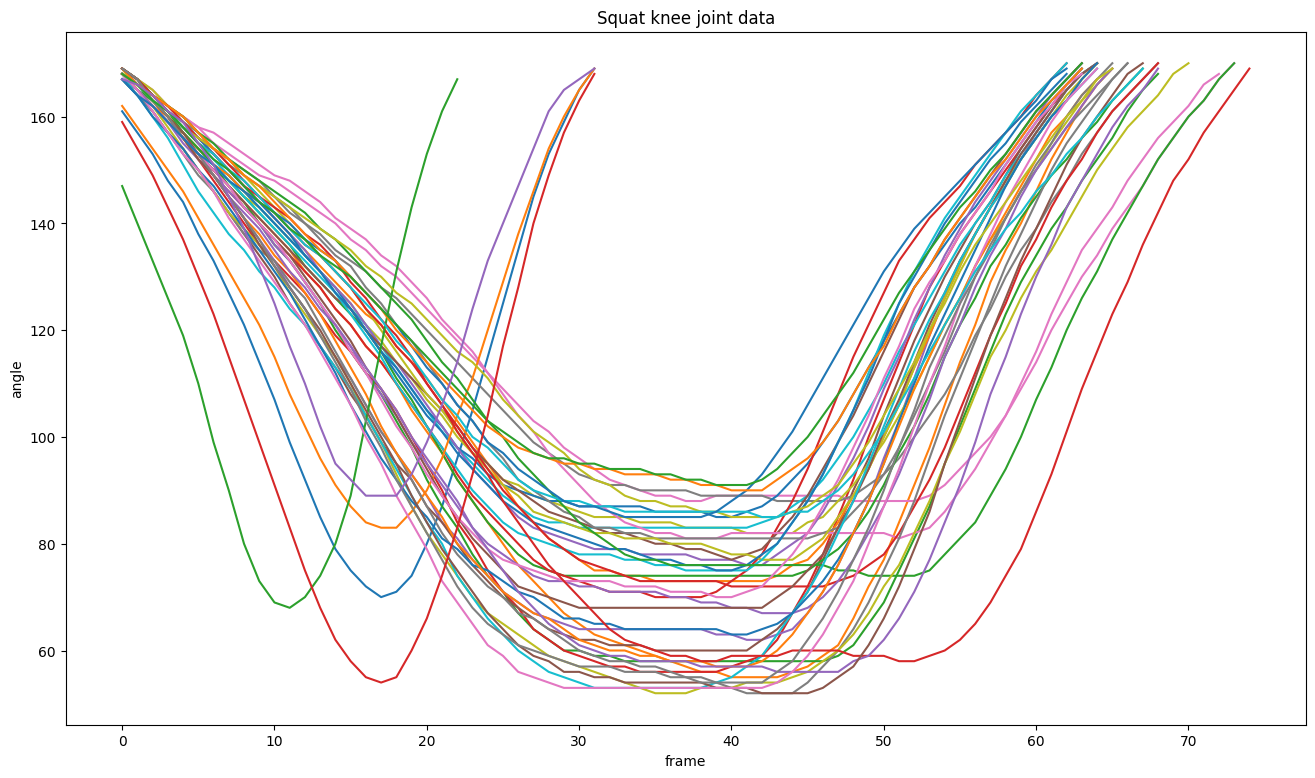

In [42]:
. plt.figure(figsize=[16,9])
for rep in squat_train_split_reps:
    plt.title(f'Squat knee joint data')
    plt.plot(rep['angles'][f'{rep["viewing from"]} knee'], label=f'{rep["viewing from"]}')
    plt.xlabel('frame')
    ''
    plt.ylabel('angle')
    #plt.legend()
plt.show()

left elbow 66
right elbow 66
left knee 66
right knee 66
right hip 66
left hip 66
left shoulder 66
right shoulder 66
tensor([1082., 1082., 1082., 1082., 1083., 1084., 1087., 1091., 1093., 1096.,
        1099., 1102., 1107., 1109., 1112., 1114., 1117., 1121., 1124., 1128.,
        1131., 1134., 1138., 1141., 1143., 1145., 1146., 1148., 1149., 1151.,
        1153., 1154., 1156., 1157., 1158., 1159., 1161., 1162., 1163., 1163.,
        1163., 1163., 1163., 1163., 1163., 1164., 1164., 1164., 1164., 1164.,
        1164., 1165., 1164., 1164., 1164., 1162., 1159., 1155., 1151., 1146.,
        1140., 1134., 1128., 1123., 1117., 1113.], dtype=torch.float64)
tensor([904., 901., 897., 893., 886., 879., 871., 860., 854., 846., 837., 827.,
        812., 803., 791., 784., 773., 759., 752., 742., 734., 724., 710., 702.,
        693., 686., 680., 671., 665., 660., 657., 652., 648., 645., 642., 640.,
        638., 637., 636., 636., 636., 635., 635., 635., 634., 633., 633., 632.,
        631., 630., 630.

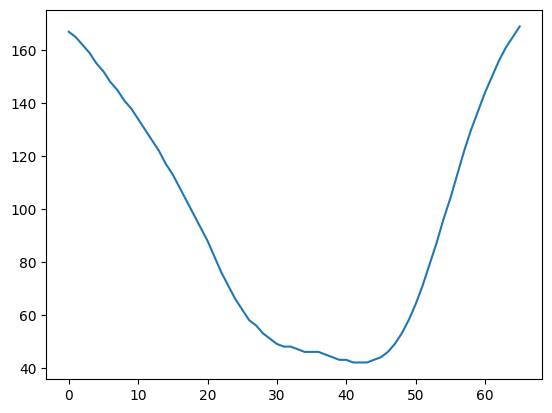

In [43]:

for key in squat_train_split_reps[1]['angles']:
    print(key, len(squat_train_split_reps[1]['angles'][key]))

for key in squat_train_split_reps[1]['points']:
    for dimension in range(len(squat_train_split_reps[1]['points'][key])):
        print(squat_train_split_reps[1]['points'][key][dimension])

plt.plot(squat_train_split_reps[1]['angles']['left knee'])

left elbow 60
right elbow 60
left knee 60
right knee 60
right hip 60
left hip 60
left shoulder 60
right shoulder 60


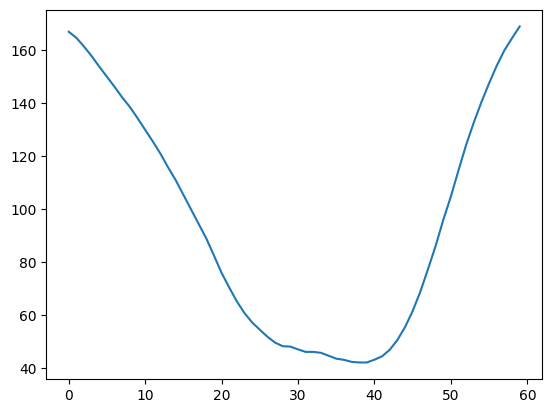

In [44]:
import torch
import torch.nn.functional as F

def resample(series: torch.Tensor, target_len: int = 60) -> torch.Tensor:
    """
    Linearly resamples a 1D tensor to target_len.
    Input:  shape (T,)
    Output: shape (target_len,)
    """
    series = series.unsqueeze(0).unsqueeze(0).to(torch.float32)  # (1,1,T)
    out = F.interpolate(series, size=target_len, mode='linear', align_corners=True)
    return out.squeeze()

for key in squat_train_split_reps[1]['angles']:
    squat_train_split_reps[1]['angles'][key] = resample(squat_train_split_reps[1]['angles'][key], target_len = 60)

for key in squat_train_split_reps[1]['angles']:
    print(key, len(squat_train_split_reps[1]['angles'][key]))

plt.plot(squat_train_split_reps[1]['angles']['left knee'])

In [45]:
for landmark in squat_train_split_reps[1]['points']:
    for dimension in range(len(squat_train_split_reps[1]['points'][landmark])):
        print(squat_train_split_reps[1]['points'][landmark])

[tensor([1082., 1082., 1082., 1082., 1083., 1084., 1087., 1091., 1093., 1096.,
        1099., 1102., 1107., 1109., 1112., 1114., 1117., 1121., 1124., 1128.,
        1131., 1134., 1138., 1141., 1143., 1145., 1146., 1148., 1149., 1151.,
        1153., 1154., 1156., 1157., 1158., 1159., 1161., 1162., 1163., 1163.,
        1163., 1163., 1163., 1163., 1163., 1164., 1164., 1164., 1164., 1164.,
        1164., 1165., 1164., 1164., 1164., 1162., 1159., 1155., 1151., 1146.,
        1140., 1134., 1128., 1123., 1117., 1113.], dtype=torch.float64), tensor([904., 901., 897., 893., 886., 879., 871., 860., 854., 846., 837., 827.,
        812., 803., 791., 784., 773., 759., 752., 742., 734., 724., 710., 702.,
        693., 686., 680., 671., 665., 660., 657., 652., 648., 645., 642., 640.,
        638., 637., 636., 636., 636., 635., 635., 635., 634., 633., 633., 632.,
        631., 630., 630., 630., 635., 640., 647., 656., 667., 691., 708., 724.,
        740., 758., 791., 808., 826., 840.], dtype=torch.f

In [46]:
# Normalize squat joints
for repetition in range(len(squat_train_split_reps)):
    for key in squat_train_split_reps[repetition]['angles']:
        squat_train_split_reps[repetition]['angles'][key] = resample(squat_train_split_reps[repetition]['angles'][key], target_len = 60)

for repetition in squat_train_split_reps:
    for key in repetition['points']:
        for dim in repetition['points'][key]:
            dim = resample(dim, target_len = 60)

In [47]:
for repetition in range(len(deadlift_train_split_reps)):
    for key in deadlift_train_split_reps[repetition]['angles']:
        deadlift_train_split_reps[repetition]['angles'][key] = resample(deadlift_train_split_reps[repetition]['angles'][key], target_len = 60)

for repetition in deadlift_train_split_reps:
    for key in repetition['points']:
        for dim in repetition['points'][key]:
            dim = resample(dim, target_len = 60)

In [48]:
for repetition in range(len(bench_train_split_reps)):
    for key in bench_train_split_reps[repetition]['angles']:
        bench_train_split_reps[repetition]['angles'][key] = resample(bench_train_split_reps[repetition]['angles'][key], target_len = 60)

for repetition in bench_train_split_reps:
    for key in repetition['points']:
        for dim in repetition['points'][key]:
            dim = resample(dim, target_len = 60)

In [49]:
# Plot squat point data
#
# plt.figure(figsize=[8,6])
# for repetition in squat_train_split_reps:
#
#     for key in repetition['points']:
#         for dim in repetition['points'][key]:
#
#             plt.title(key)
#             plt.plot(dim)
#         plt.show()

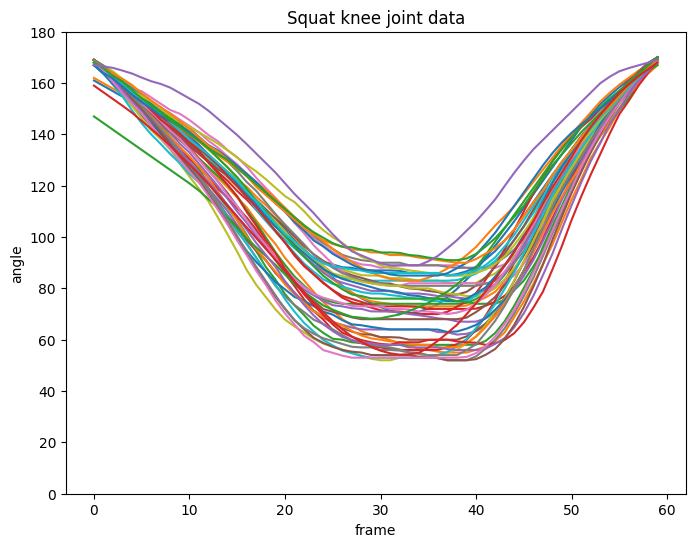

In [50]:
plt.figure(figsize=[8,6])
for rep in squat_train_split_reps:
    plt.title(f'Squat knee joint data')
    plt.plot(rep['angles'][f'{rep["viewing from"]} knee'], label=f'{rep["viewing from"]}')
    plt.xlabel('frame')
    ''
    plt.ylabel('angle')
    plt.ylim(0,180)
    #plt.legend()
plt.show()

# i = 1
# for rep in squat_train_split_reps:
#     plt.figure(figsize=[8,6])
#     plt.title(f'Squat knee joint data ( rep {i})')
#     plt.plot(rep['angles'][f'{rep["viewing from"]} knee'], label=f'{rep["viewing from"]}')
#     plt.xlabel('frame')
#     ''
#     plt.ylabel('angle')
#     #plt.legend()
#     plt.show()
#     i += 1

In [51]:
import torch

# KNEE ---------------------------------------------------
squat_knee_all_reps = []
for rep in squat_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} knee']  # this is already a tensor
    squat_knee_all_reps.append(series)

# ---------------------------------------------------------

# HIP ---------------------------------------------------
squat_hip_all_reps = []
for rep in squat_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} hip']  # this is already a tensor
    squat_hip_all_reps.append(series)

# ---------------------------------------------------------

# ELBOW ---------------------------------------------------
squat_elbow_all_reps = []
for rep in squat_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} elbow']  # this is already a tensor
    squat_elbow_all_reps.append(series)

# ---------------------------------------------------------

# SHOULDER ---------------------------------------------------
squat_shoulder_all_reps = []
for rep in squat_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} shoulder']  # this is already a tensor
    squat_shoulder_all_reps.append(series)
# ---------------------------------------------------------

squat_knee_angles_matrix = torch.stack(squat_knee_all_reps)  # shape (num_reps, num_frames)
squat_hip_angles_matrix = torch.stack(squat_hip_all_reps)  # shape (num_reps, num_frames)
squat_elbow_angles_matrix = torch.stack(squat_elbow_all_reps)  # shape (num_reps, num_frames)
squat_shoulder_angles_matrix = torch.stack(squat_shoulder_all_reps)  # shape (num_reps, num_frames)

mean, lower, upper = functions.compute_normal_credible_interval(squat_knee_angles_matrix)

In [52]:
# KNEE ---------------------------------------------------
deadlift_knee_all_reps = []
for rep in deadlift_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} knee']  # this is already a tensor
    deadlift_knee_all_reps.append(series)

# ---------------------------------------------------------

# HIP ---------------------------------------------------
deadlift_hip_all_reps = []
for rep in deadlift_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} hip']  # this is already a tensor
    deadlift_hip_all_reps.append(series)

# ---------------------------------------------------------

# ELBOW ---------------------------------------------------
deadlift_elbow_all_reps = []
for rep in deadlift_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} elbow']  # this is already a tensor
    deadlift_elbow_all_reps.append(series)

# ---------------------------------------------------------

# SHOULDER ---------------------------------------------------
deadlift_shoulder_all_reps = []
for rep in deadlift_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} shoulder']  # this is already a tensor
    deadlift_shoulder_all_reps.append(series)
# ---------------------------------------------------------

deadlift_knee_angles_matrix = torch.stack(deadlift_knee_all_reps)  # shape (num_reps, num_frames)
deadlift_hip_angles_matrix = torch.stack(deadlift_hip_all_reps)  # shape (num_reps, num_frames)
deadlift_elbow_angles_matrix = torch.stack(deadlift_elbow_all_reps)  # shape (num_reps, num_frames)
deadlift_shoulder_angles_matrix = torch.stack(deadlift_shoulder_all_reps)  # shape (num_reps, num_frames)

In [53]:
# KNEE ---------------------------------------------------
bench_knee_all_reps = []
for rep in bench_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} knee']  # this is already a tensor
    bench_knee_all_reps.append(series)

# ---------------------------------------------------------

# HIP ---------------------------------------------------
bench_hip_all_reps = []
for rep in bench_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} hip']  # this is already a tensor
    bench_hip_all_reps.append(series)

# ---------------------------------------------------------

# ELBOW ---------------------------------------------------
bench_elbow_all_reps = []
for rep in bench_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} elbow']  # this is already a tensor
    bench_elbow_all_reps.append(series)

# ---------------------------------------------------------

# SHOULDER ---------------------------------------------------
bench_shoulder_all_reps = []
for rep in bench_train_split_reps:
    side = rep["viewing from"]
    series = rep['angles'][f'{side} shoulder']  # this is already a tensor
    bench_shoulder_all_reps.append(series)
# ---------------------------------------------------------

bench_knee_angles_matrix = torch.stack(bench_knee_all_reps)  # shape (num_reps, num_frames)
bench_hip_angles_matrix = torch.stack(bench_hip_all_reps)  # shape (num_reps, num_frames)
bench_elbow_angles_matrix = torch.stack(bench_elbow_all_reps)  # shape (num_reps, num_frames)
bench_shoulder_angles_matrix = torch.stack(bench_shoulder_all_reps)  # shape (num_reps, num_frames)

In [54]:
squat_knee_samples = functions.run_mcmc(squat_knee_angles_matrix)
squat_hip_samples = functions.run_mcmc(squat_hip_angles_matrix)
squat_elbow_samples = functions.run_mcmc(squat_elbow_angles_matrix)
squat_shoulder_samples = functions.run_mcmc(squat_shoulder_angles_matrix)
deadlift_knee_samples = functions.run_mcmc(deadlift_knee_angles_matrix)
deadlift_hip_samples = functions.run_mcmc(deadlift_hip_angles_matrix)
deadlift_elbow_samples = functions.run_mcmc(deadlift_elbow_angles_matrix)
deadlift_shoulder_samples = functions.run_mcmc(deadlift_shoulder_angles_matrix)
bench_knee_samples = functions.run_mcmc(bench_knee_angles_matrix)
bench_hip_samples = functions.run_mcmc(bench_hip_angles_matrix)
bench_elbow_samples = functions.run_mcmc(bench_elbow_angles_matrix)
bench_shoulder_samples = functions.run_mcmc(bench_shoulder_angles_matrix)

Warmup:   1%|          | 13/1600 [00:00, 30.44it/s, step size=1.60e-02, acc. prob=0.846]

KeyboardInterrupt: 

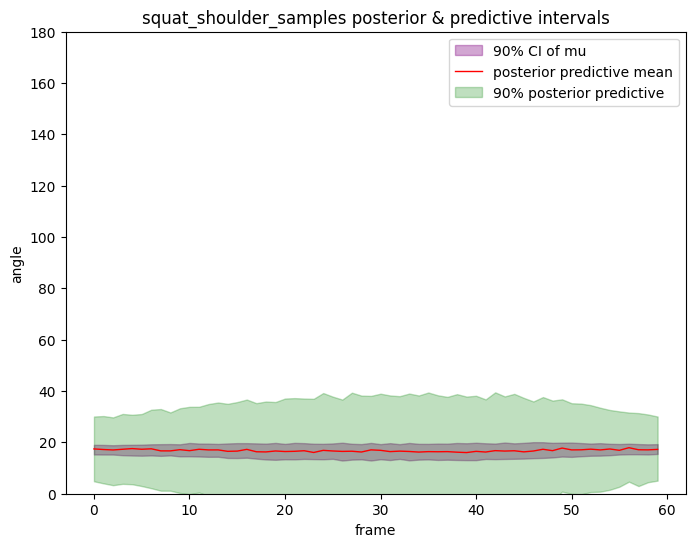

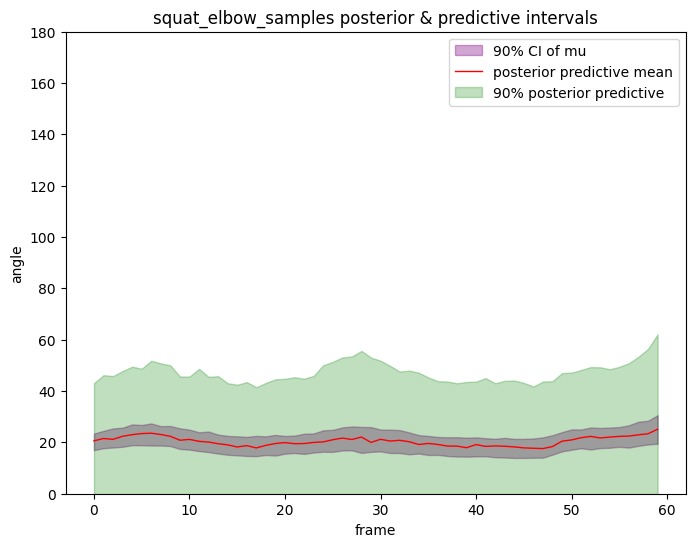

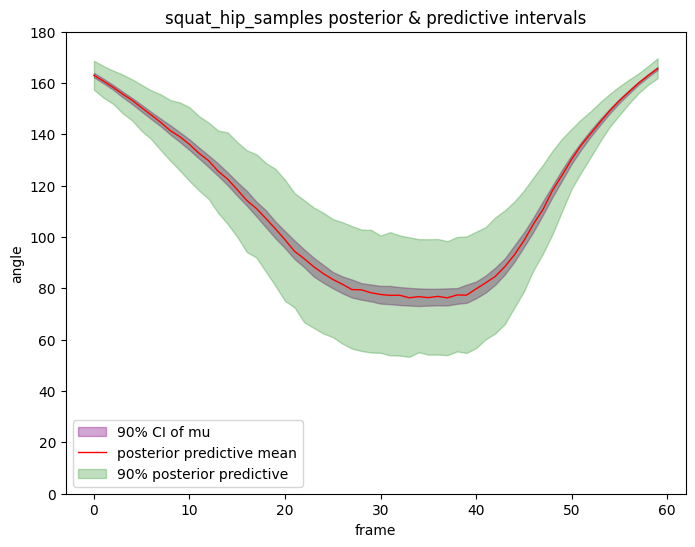

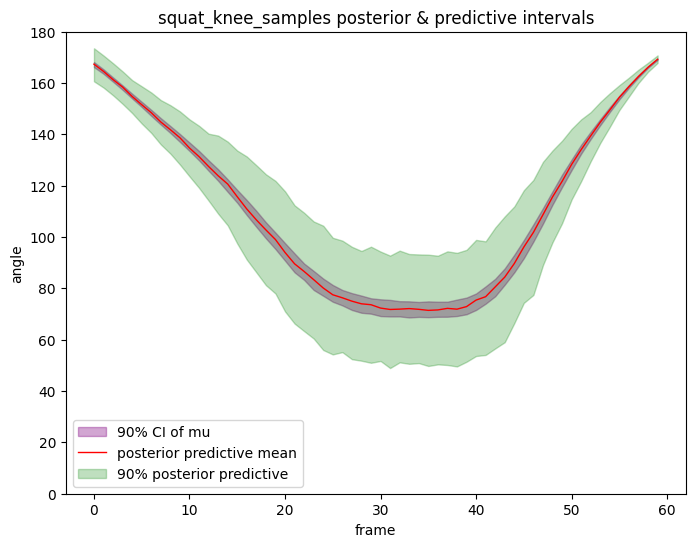

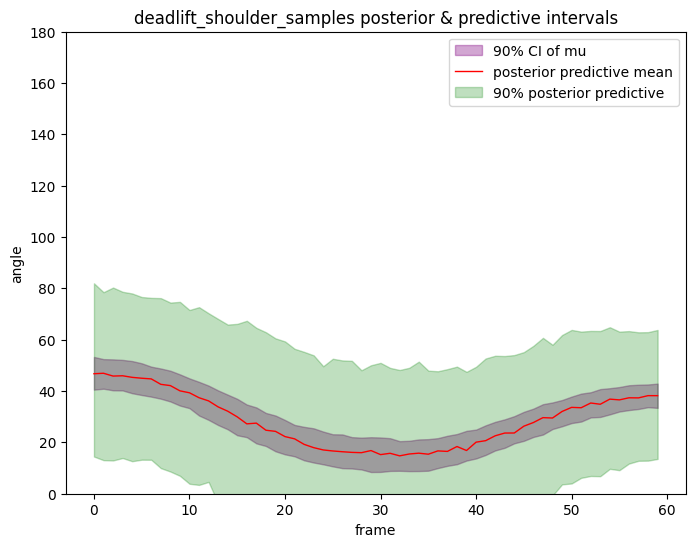

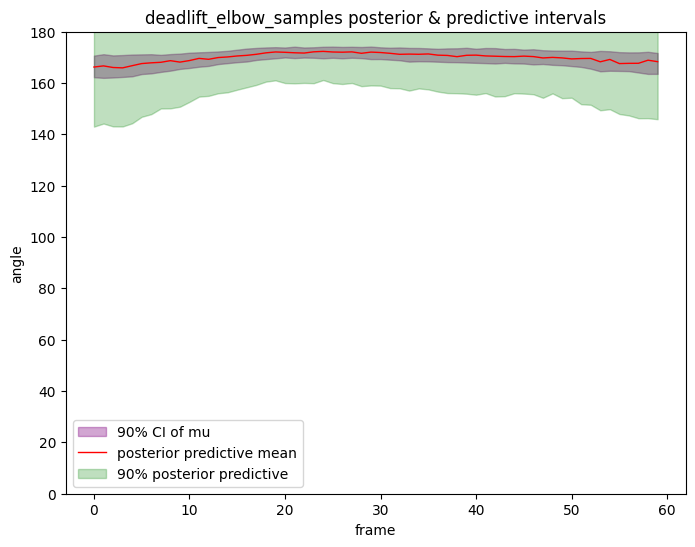

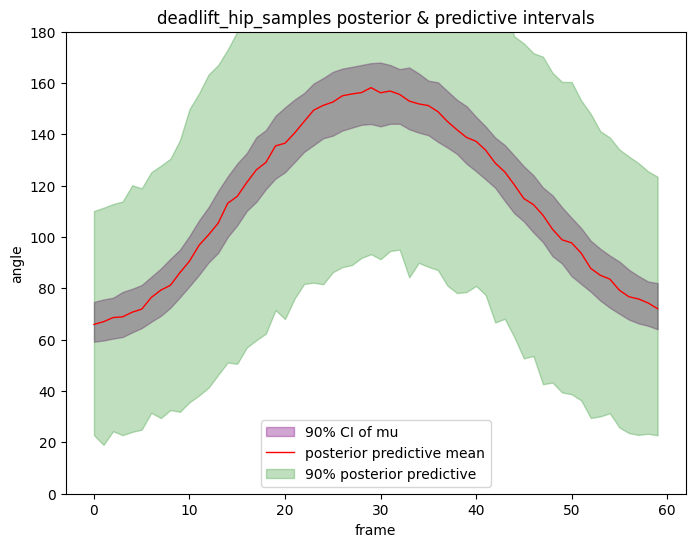

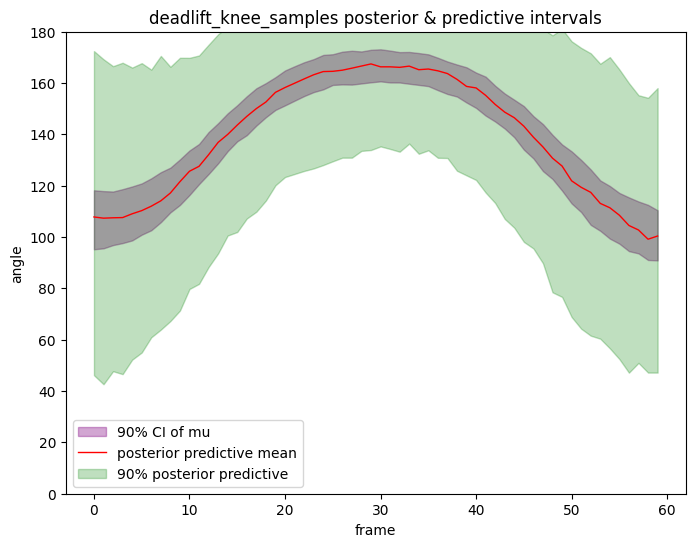

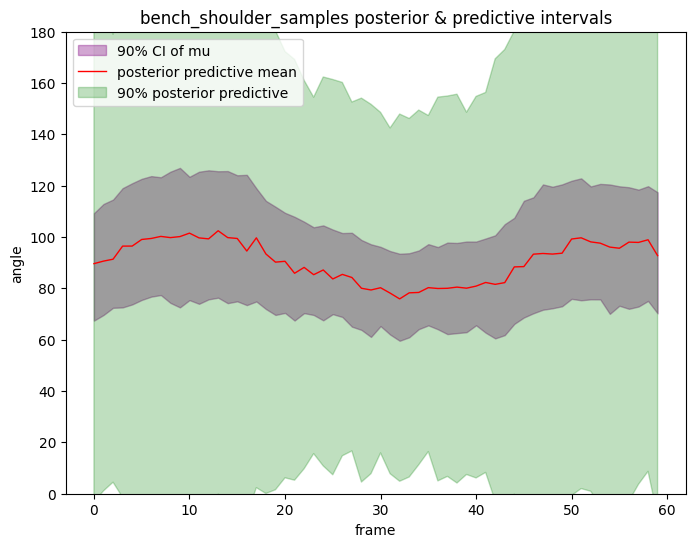

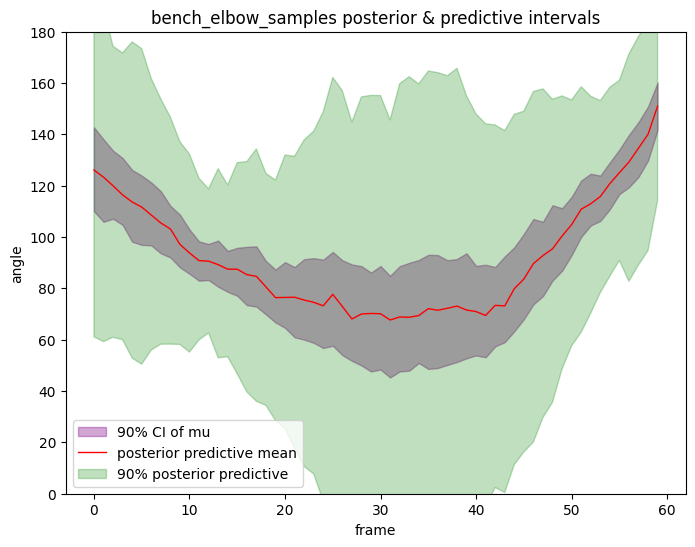

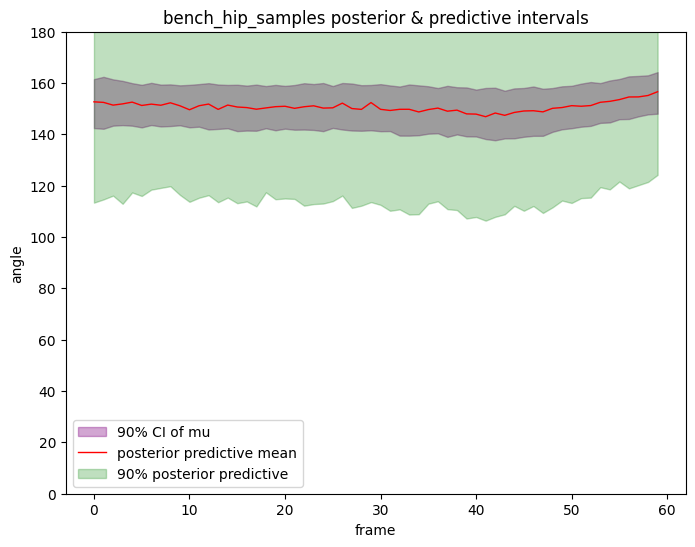

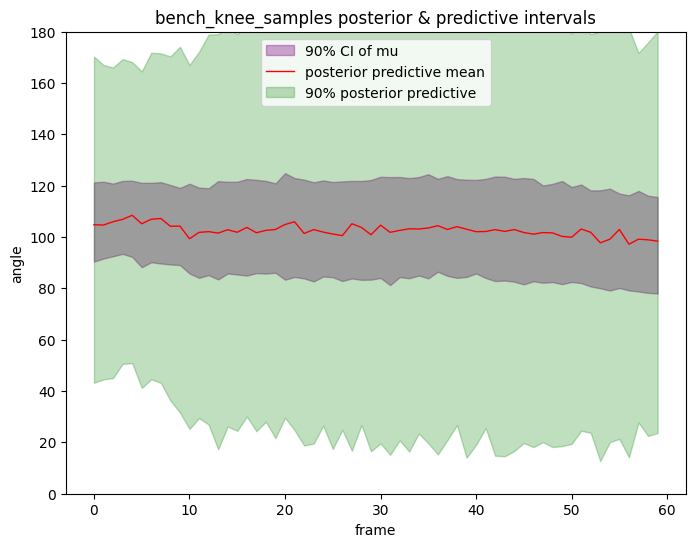

In [56]:
functions.summarize_and_plot(squat_shoulder_samples, data = squat_knee_angles_matrix, title="squat_shoulder_samples")
functions.summarize_and_plot(squat_elbow_samples, data = squat_knee_angles_matrix, title="squat_elbow_samples")
functions.summarize_and_plot(squat_hip_samples, data = squat_knee_angles_matrix, title="squat_hip_samples")
functions.summarize_and_plot(squat_knee_samples, data = squat_knee_angles_matrix, title="squat_knee_samples")
functions.summarize_and_plot(deadlift_shoulder_samples, data = squat_knee_angles_matrix, title="deadlift_shoulder_samples")
functions.summarize_and_plot(deadlift_elbow_samples, data = squat_knee_angles_matrix, title="deadlift_elbow_samples")
functions.summarize_and_plot(deadlift_hip_samples, data = squat_knee_angles_matrix, title="deadlift_hip_samples")
functions.summarize_and_plot(deadlift_knee_samples, data = squat_knee_angles_matrix, title="deadlift_knee_samples")
functions.summarize_and_plot(bench_shoulder_samples, data = squat_knee_angles_matrix, title="bench_shoulder_samples")
functions.summarize_and_plot(bench_elbow_samples, data = squat_knee_angles_matrix, title="bench_elbow_samples")
functions.summarize_and_plot(bench_hip_samples, data = squat_knee_angles_matrix, title="bench_hip_samples")
functions.summarize_and_plot(bench_knee_samples, data = squat_knee_angles_matrix, title="bench_knee_samples")

In [58]:
np.savez(
    "lift_samples.npz",
    squat_knee=squat_knee_samples,
    squat_hip=squat_hip_samples,
    squat_elbow=squat_elbow_samples,
    squat_shoulder=squat_shoulder_samples,
    deadlift_knee=deadlift_knee_samples,
    deadlift_hip=deadlift_hip_samples,
    deadlift_elbow=deadlift_elbow_samples,
    deadlift_shoulder=deadlift_shoulder_samples,
    bench_knee=bench_knee_samples,
    bench_hip=bench_hip_samples,
    bench_elbow=bench_elbow_samples,
    bench_shoulder=bench_shoulder_samples
)